In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import os
import sys
import glob
import platform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [4]:
if 'Windows' in platform.platform() and '8.1' in platform.release():
    _ = "C:\\Users\\Andrey\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = None
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '7' in platform.release():
    _ = "E:\\Disk.Yandex\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "E:\\Disk.Yandex\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"

elif 'Windows' in platform.platform() and '10' in platform.release():
    _ = "F:\\YandexDisk\\3.Programing\\"
    DATA_DIR = _ + "work\\PulseViewer\\pulsarsData\\"
    PATTERN_DIR = _ + "work\\PulseViewer\\frame_of_AP\\patterns\\"
    PACK_DIR = _ + "myPacks\\"
    ALL_DATA = "F:\\YandexDisk\\1.Работа\\Результаты обработки\\"
    DELIMITER = "\\"
    
elif 'Linux' in platform.platform() and '4.4.0' in platform.release():
    _ = "/home/andr/Yandex.Disk/3.Programing/"
    DATA_DIR = _ + "work/PulseViewer/pulsarsData/"
    PATTERN_DIR = _ + "/work/PulseViewer/frame_of_AP/patterns/"
    PACK_DIR = _ + "myPacks/"
    ALL_DATA = "/home/andr/Yandex.Disk/1.Работа/Результаты обработки/"
    DELIMITER = "/"
    
else:
    print('unknown system', platform.platform(), platform.release())
    
sys.path.append(PACK_DIR)
from PRAO import *

In [185]:
name = '0531+21'
data = '24.04.2018'
day, month, year = data.split('.')

In [186]:
dir_file = (ALL_DATA  + name + DELIMITER + year + DELIMITER + month + year[2:] + DELIMITER)

In [187]:
files_txt = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*_profiles.txt'))
files_srez = sorted(glob.glob(dir_file + day + month + year[2:] + '*' + name + '*.srez'))
files = np.append(files_txt, files_srez)

In [188]:
files

array(['F:\\YandexDisk\\1.Работа\\Результаты обработки\\0531+21\\2018\\0418\\240418_0531+21_00_profiles.txt'],
      dtype='<U92')

In [189]:
head, main_pulse, data_pulses, back = read_profiles_MD(files[0])

In [190]:
diag = []
for x in tqdm_notebook(np.linspace(-1.2, 1.2, len(obser) + int(head['numpointwin']))):
    if x == 0:
        diag.append(1)
    else:
        diag.append((np.sin(x)/x)**2)

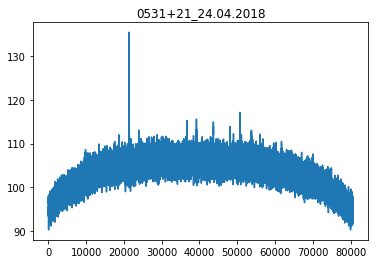

In [191]:
non_cor_data = []
for pulse, backg in zip(data_pulses, back):
    non_cor_data.append(pulse + backg)
obser = np.hstack(non_cor_data)
plt.close()
plt.title(name + '_' + data)
plt.plot(obser)
#plt.plot(np.array(diag), color='r')
plt.show()

In [192]:
cor_d = []
for data_point, coeff in zip(obser, diag):
    cor_d.append(data_point/coeff)
cor_d = np.asarray(cor_d)

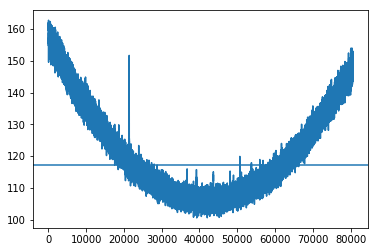

In [193]:
plt.close()
plt.plot(cor_d)
plt.axhline(np.median(cor_d))
plt.show()

In [194]:
med_flux = np.median(cor_d)
cor_d = cor_d.reshape(int(head['numpuls'])-1, int(head['numpointwin']))

In [195]:
final_array = []
for pulse in cor_d:
    l_edge = np.median(pulse[:6])
    r_edge = np.median(pulse[-5:])
    array_coef = np.linspace(l_edge, r_edge, len(pulse))
    coef_pulse = []
    for point, cf in zip(pulse, array_coef):
        coef_pulse.append(point-cf + med_flux)
    final_array.append(coef_pulse)
final_array = np.asarray(final_array)
flat_obser = np.hstack(final_array)

In [196]:
flat_obser = flat_obser - np.median(flat_obser)
flat_obser_calib = flat_obser + 1720 # Калибровка в Янские(согласнго статье)

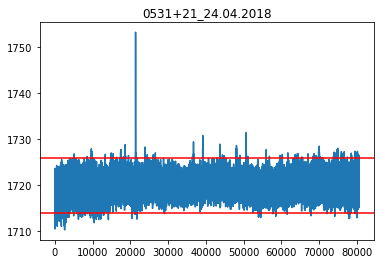

In [197]:
plt.close()
plt.title(name + '_' + data)
plt.plot(flat_obser_calib) #[24150:24300]
#plt.axhline(1800, color='r')
plt.axhline(np.median(flat_obser_calib) + 3*np.std(flat_obser_calib), color='red')
plt.axhline(np.median(flat_obser_calib) - 3*np.std(flat_obser_calib), color='red')
#plt.axhline(np.min(flat_obser), color='green')
#plt.axhline(np.median(flat_obser_calib), color='r')
#plt.axhline(np.median(flat_obser_calib)*3, color='pink')
#plt.savefig('crab_observ_' + head['date'] + '.png', format='png', dpi=100)
plt.show()

In [199]:
thres = 1726
giant_pulses = [[]]
i = 0
for point in flat_obser_calib:
    if point >= thres:
        giant_pulses[i].append(point)
    else:
        giant_pulses.append([])
        i +=1
giant_pulses = [i for i in giant_pulses if len(i)>0]

In [200]:
len(giant_pulses)

152

In [201]:
x_max = np.argmax(flat_obser_calib)

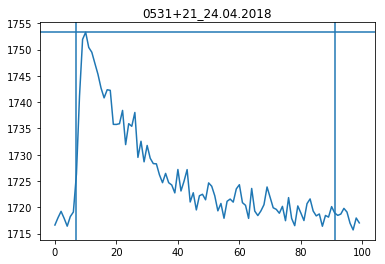

In [202]:
pulse = flat_obser_calib[x_max - 10: x_max + 90]
plt.close()
plt.title(name + '_' + data)
plt.plot(pulse)

plt.axhline(np.max(pulse))
#plt.axhline(0.5*np.max(pulse))
#plt.axhline(0.1*np.max(pulse))

plt.axvline(7)
plt.axvline(91)

plt.show()